In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/requirement-txt/requirements.txt
/kaggle/input/airlines-booking-csv/customer_booking.csv
/kaggle/input/airline-booking-dag/causal_model_modified.png.png


In [3]:
import os
req_path = "/kaggle/input/requirement-txt"
os.chdir(req_path)
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 58.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [4]:
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 12.1 MB/s eta 0:00:0000:01


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import econml as eml
import shap
from dowhy import CausalModel
from dowhy.datasets import sales_dataset
from dowhy.utils import plot, bar_plot
from dowhy import gcm
import causallearn
import ydata_profiling as pp
import networkx as nx
import dcor
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

pd.set_option('display.max_columns', None)

In [12]:
data = pd.read_csv("/kaggle/input/airlines-booking-csv/customer_booking.csv", encoding='unicode_escape')

In [6]:
data

NameError: name 'data' is not defined

**Data Cleaning and Preprocessing**

In [8]:
def get_missingness_skew(df):
    """
    Returns a DataFrame containing information on the missingness and skewness of each column in the input DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame whose columns need to be analyzed.

    Returns:
        pd.DataFrame: A DataFrame containing columns for each column name, its data type, number of distinct values, 
                      number and percentage of missing values, and its skewness.
    """
    # Adjust the float format for displaying results
    pd.options.display.float_format = '{:,.4f}'.format

    # Create the summary DataFrame
    missingness_skew_df = pd.DataFrame([
        {
            'column': c,
            'dtype': df[c].dtype,
            'distinct': df[c].nunique(),
            '#_missing_val': df[c].isnull().sum(),
            '%missingness': df[c].isnull().sum() * 100 / len(df),
            'skewness': df[c].value_counts(normalize=True).values[0] * 100 if len(df[c].dropna()) > 0 else 0
        }
        for c in df.columns
    ])

    # Sort by the percentage of missing values in descending order
    missingness_skew_df = missingness_skew_df.sort_values('%missingness', ascending=False)

    # Return the top 100 results
    return missingness_skew_df

get_missingness_skew(data)

,column,dtype,distinct,#_missing_val,%missingness,skewness
0,num_passengers,int64,9,0,0.0000,62.7040
1,sales_channel,object,2,0,0.0000,88.7640
2,trip_type,object,3,0,0.0000,98.9940
3,purchase_lead,int64,470,0,0.0000,1.3700
4,length_of_stay,int64,335,0,0.0000,15.5140
5,flight_hour,int64,24,0,0.0000,6.3300
6,flight_day,object,7,0,0.0000,16.2040
7,route,object,799,0,0.0000,5.3600
8,booking_origin,object,104,0,0.0000,35.7440
9,wants_extra_baggage,int64,2,0,0.0000,66.8780


In [10]:
Cat_cols =['sales_channel', 'trip_type', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_day']
Target = ['booking_complete']
Num_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
Cat_cols2 = ['route', 'booking_origin']

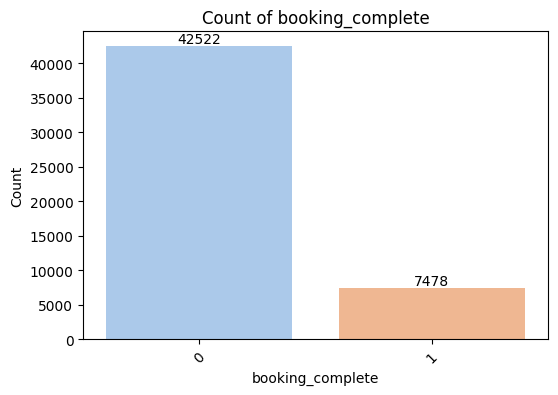

In [27]:
for column in Target:
        plt.figure(figsize=(6,4))
        ax = sns.countplot(x=column, data=data)
        plt.title(f'Count of {column}')
        plt.xlabel(column)
        #rotate x axis value by 45
        plt.xticks(rotation=45)
        plt.ylabel('Count')

        # Annotate each bar with its count
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center',
                        xytext = (0, 5),
                        textcoords = 'offset points')
        plt.show()


Only 15% of all bookings have been completed. We will explore the factors that influence these outcomes.



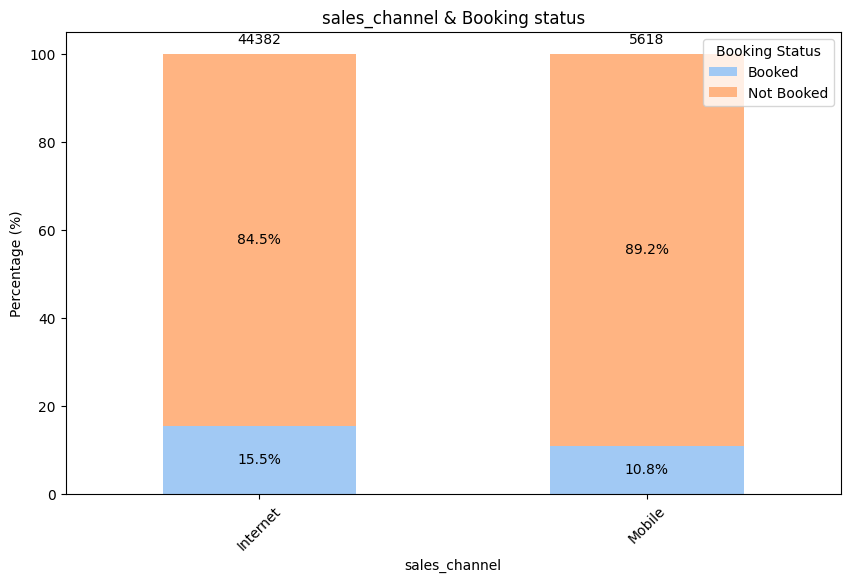

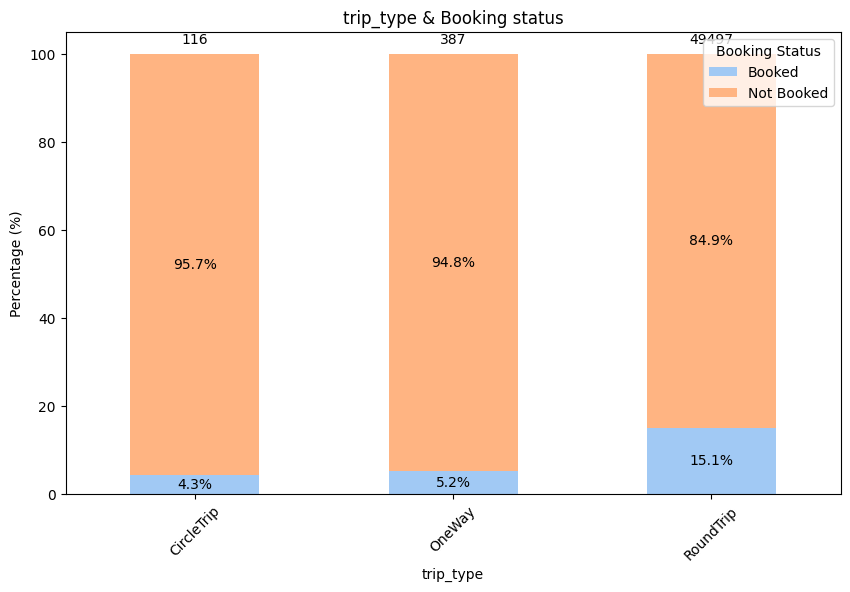

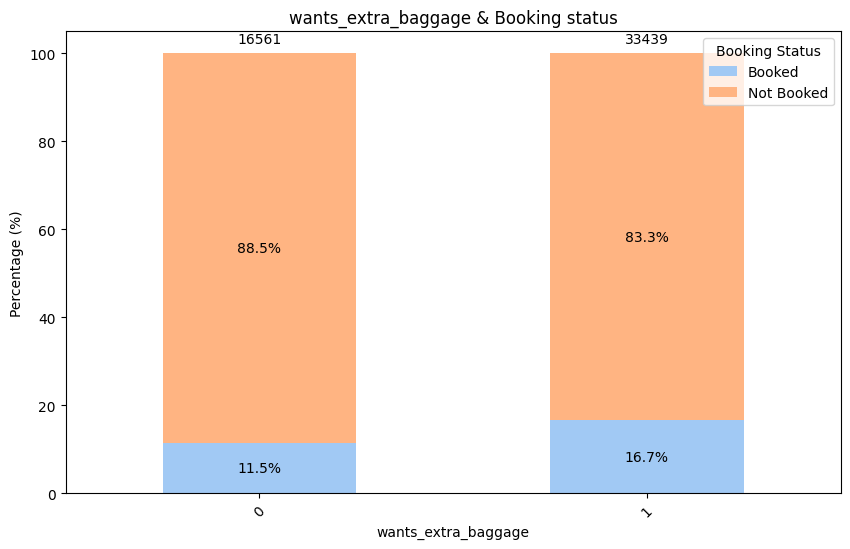

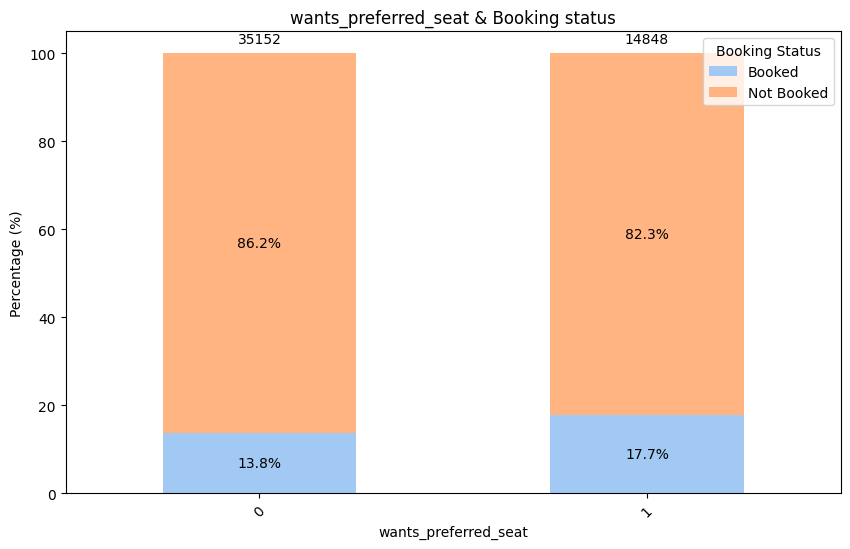

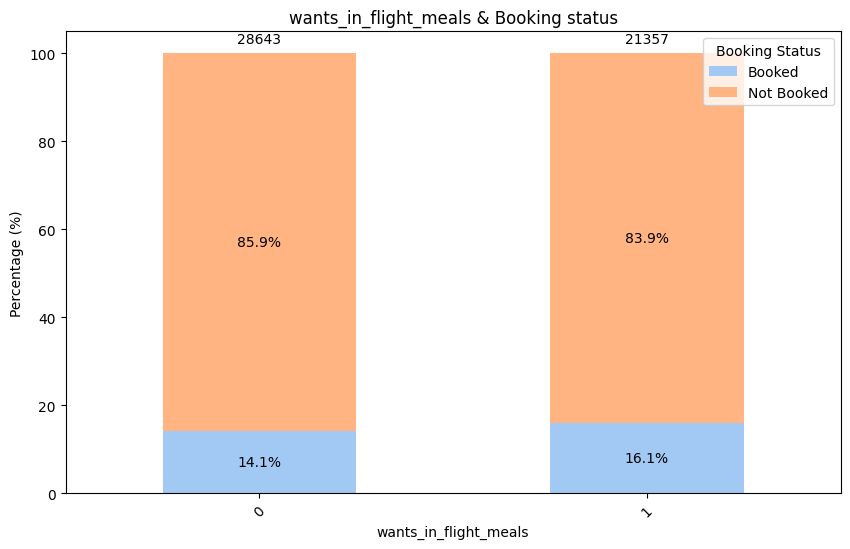

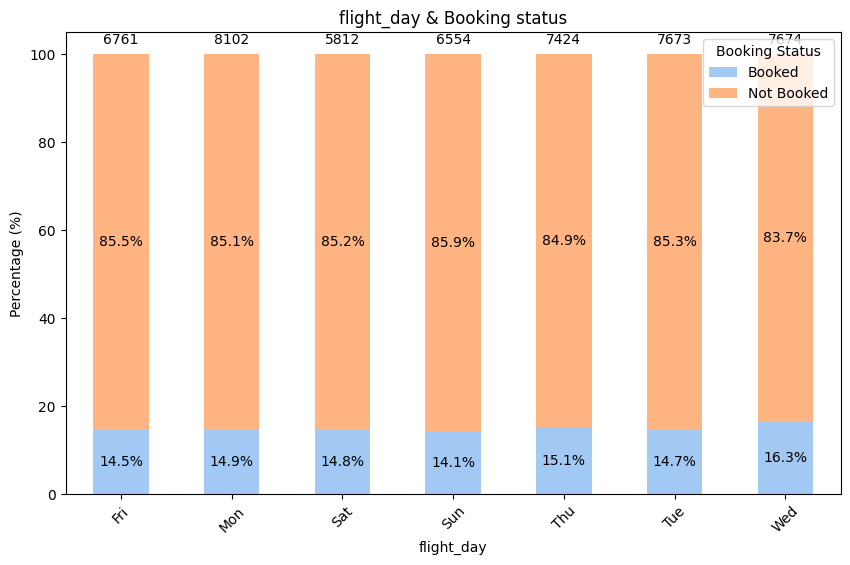

In [25]:
sns.set_palette('pastel')

for column in Cat_cols:
    cross_tab = pd.crosstab(index=data[column], columns=data['booking_complete'].map({0: 'Not Booked', 1: 'Booked'}))
    row_sums = cross_tab.sum(axis=1)

    cross_tab_percent = cross_tab.div(row_sums, axis=0) * 100

    ax = cross_tab_percent.plot(kind='bar', stacked=True, figsize=(10, 6))

    plt.title(f'{column} & Booking status')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.ylabel('Percentage (%)')

    for bars in ax.containers:
        ax.bar_label(bars, label_type='center', fmt='%.1f%%')


    for rect, total_count in zip(ax.patches[:len(row_sums)], row_sums):

        height = sum([p.get_height() for p in ax.patches if p.get_x() == rect.get_x()])
        ax.annotate(f'{total_count}',
                    (rect.get_x() + rect.get_width() / 2, height),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

    plt.legend(title='Booking Status', loc='upper right')
    plt.show()

**Insights**

***Sales Channel***:
Most of the interactions has been through internet channel, and also the actually count of bookings made here is 6880.

***trip_type***:
Most of the bookings are of type "Round Trip", meaning to and fro between two destinations, One way and Circle trip are considerably low

***Extra Baggage***:
There is a slightly higher tendency for bookings to be completed among passengers who want extra baggage compared to those who do not.
Despite this, the majority of both groups have not completed their bookings, indicating that wanting extra baggage may not be a strong indicator of whether a booking will be completed. 

***Seat Preference***:
There appears to be a slightly higher completion rate for bookings among those who want a preferred seat compared to those who do not.

***Day of the week***:
Wednesdays show the highest percentage of booked flights at 16.3%, whereas Sundays have the lowest at 14.1%.
Notably, the total count of flights varies significantly between days, with Monday being the busiest with 8102 flights and Saturday the least busy with 5812 flights.

In [29]:
booking_origin_counts = data['booking_origin'].value_counts()
top_n = booking_origin_counts.head(10)

In [33]:
top_n

booking_origin
Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
Indonesia       2369
Taiwan          2077
Thailand        2030
India           1270
New Zealand     1074
Name: count, dtype: int64

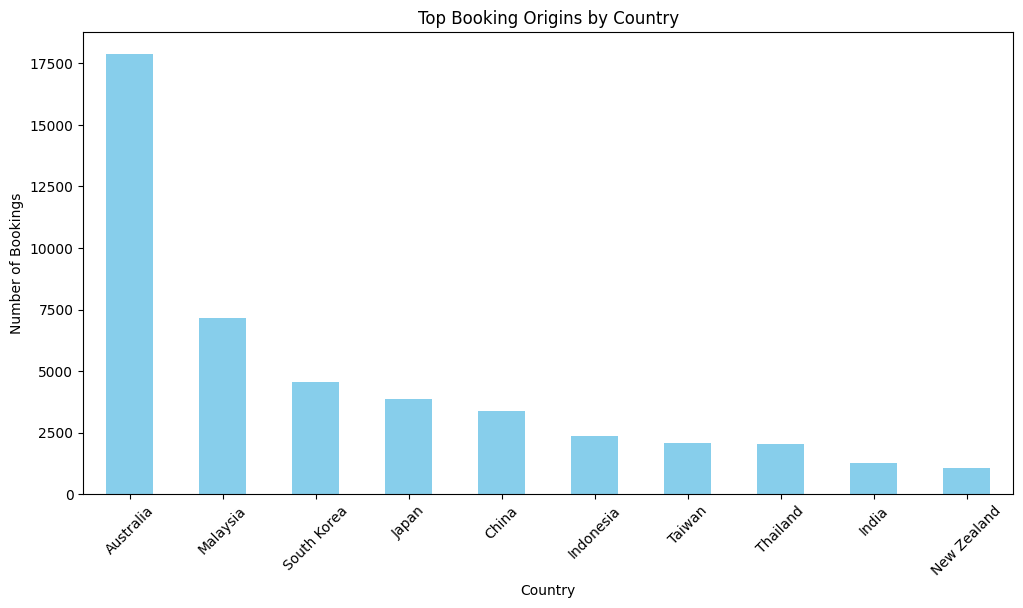

In [30]:
plt.figure(figsize=(12, 6))
top_n.plot(kind='bar', color='skyblue')

plt.title('Top Booking Origins by Country')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.show()

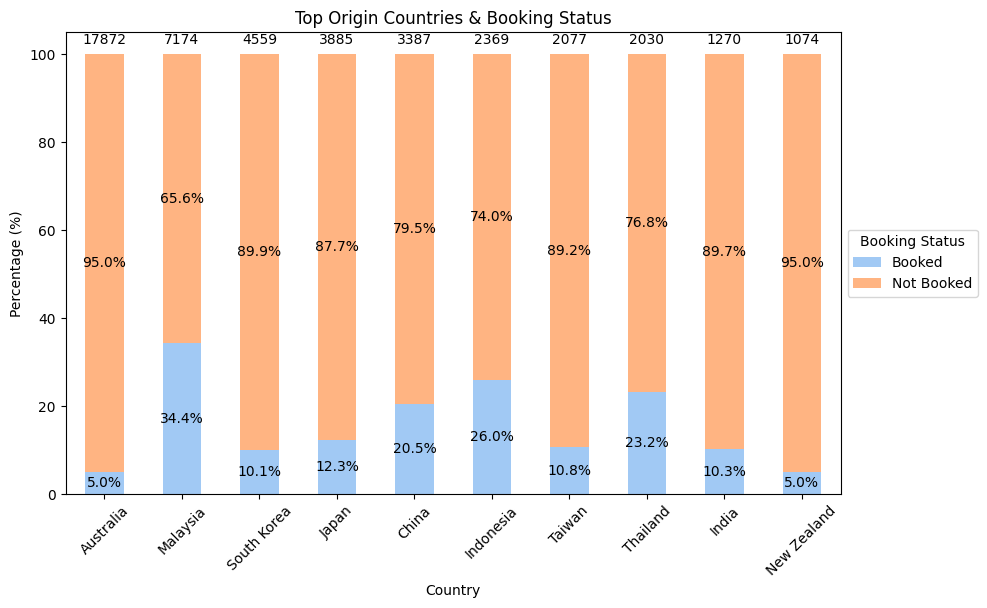

In [35]:

cross_tab = pd.crosstab(index=data['booking_origin'], columns=data['booking_complete'].map({0: 'Not Booked', 1: 'Booked'}))
row_sums = cross_tab.sum(axis=1)
cross_tab_percent = cross_tab.div(row_sums, axis=0) * 100

N = 10 
top_n_origins = row_sums.nlargest(N).index

top_n_cross_tab_percent = cross_tab_percent.loc[top_n_origins]

ax = top_n_cross_tab_percent.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Top Origin Countries & Booking Status')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Percentage (%)')

for bars in ax.containers:
    ax.bar_label(bars, label_type='center', fmt='%.1f%%')

for rect, total_count in zip(ax.patches[:len(top_n_origins)], row_sums[top_n_origins]):
    height = sum([p.get_height() for p in ax.patches if p.get_x() == rect.get_x()])
    ax.annotate(f'{total_count}', 
                (rect.get_x() + rect.get_width() / 2, height), 
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.legend(title='Booking Status', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

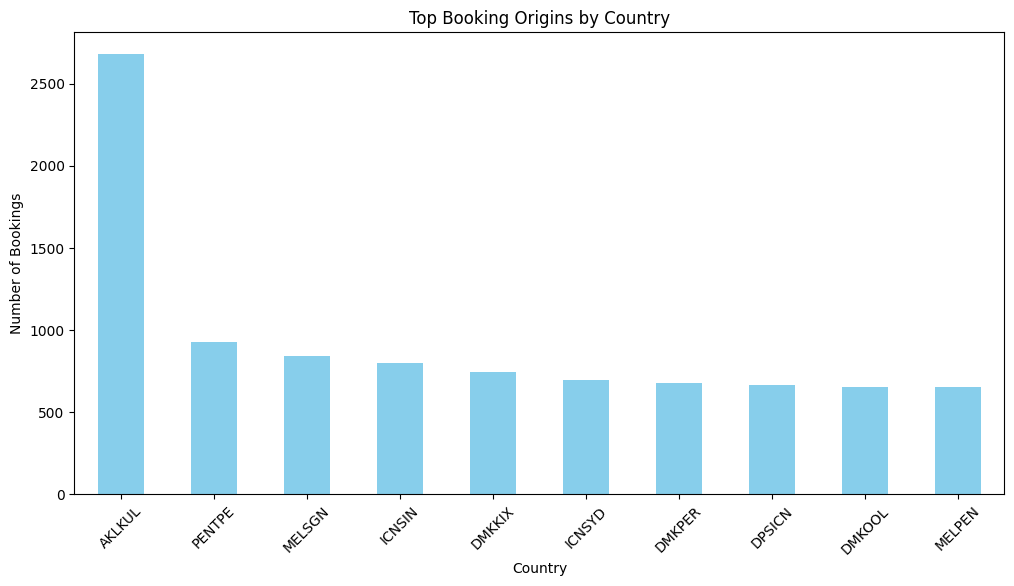

In [38]:
route_counts = data['route'].value_counts()
top_10_routes = route_counts.head(10)

plt.figure(figsize=(12, 6))
top_10_routes.plot(kind='bar', color='skyblue')

plt.title('Top Booking Origins by Country')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


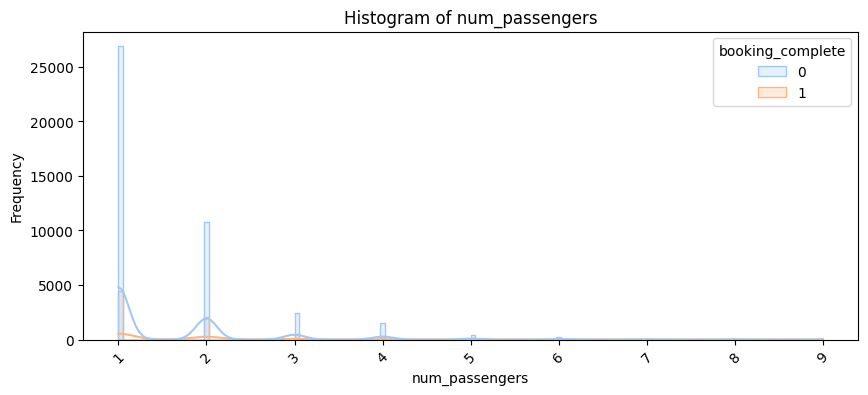

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


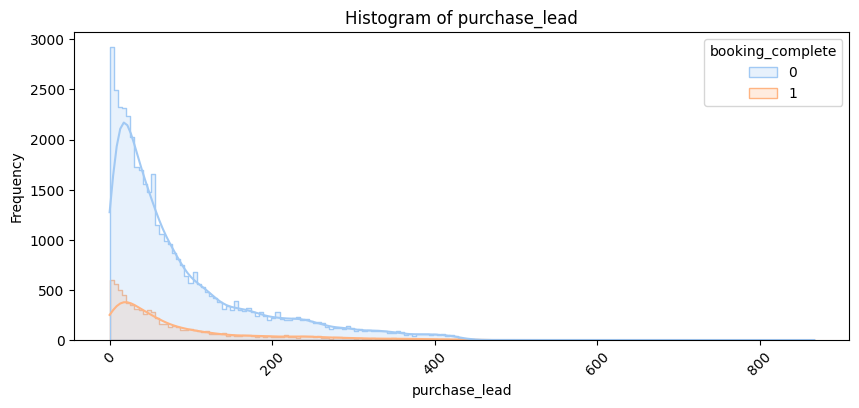

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


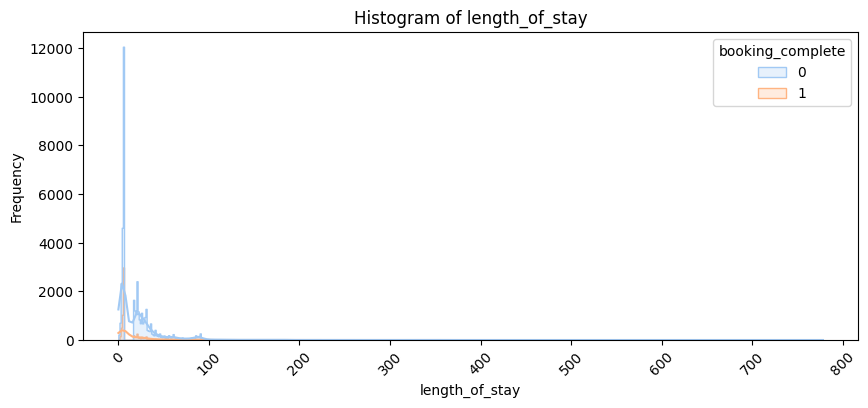

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


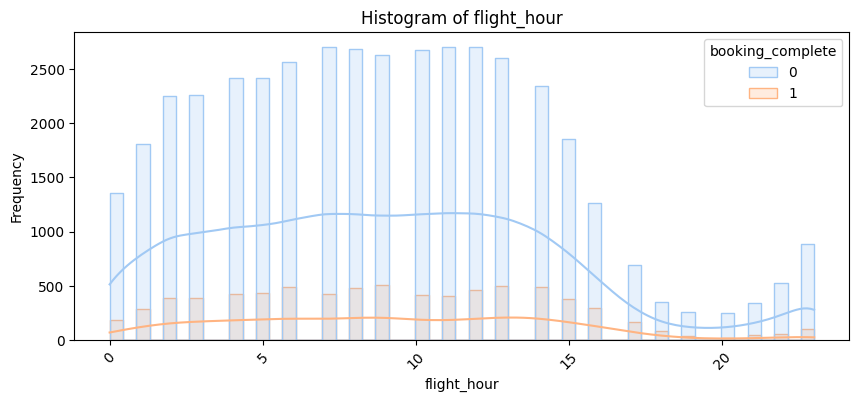

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


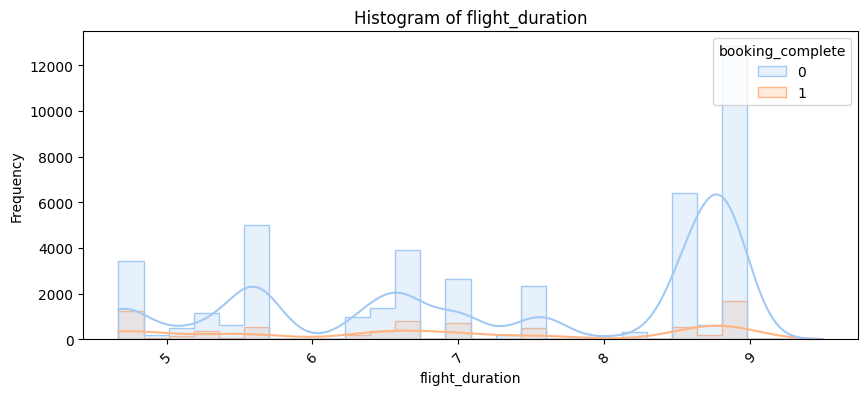

In [40]:
for column in Num_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(data=data, x=column, hue='booking_complete', kde=True, element='step', palette='pastel')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.xticks(rotation=45)
        plt.ylabel('Frequency')
        plt.show()

***Flight hours***:
 * Completed bookings seem to have peaks around the 5th, 8th, and 19th hours. These could represent popular times for flights, perhaps due to typical work hours or flight schedules.
 * Conversely, there are hours such as around the 0th, 13th, and beyond the 21st hour where there are notably fewer completed bookings. These hours might be less convenient for travelers or could correspond to night times or early mornings.
 
***Flight Duration*** 
 *  There is a large peak for incomplete bookings (blue bars) at the highest flight duration category just before the 10-unit mark. This suggests a tendency for bookings for longer flights to be initiated but not completed.
 *  The prominent peak for incomplete bookings suggests an opportunity to focus customer engagement efforts on those considering longer flights, perhaps by addressing concerns or offering additional support or incentives.
 
***Purchase Lead Time***
 *  There is a steep drop-off in frequency as the purchase lead time increases, showing that most purchases, whether completed or not, tend to occur with shorter lead times.
 *  The decrease in the frequency of completed bookings is steadier, implying that while fewer people book flights with long lead times, those who do are more committed to their purchase.
 *  this information can be used to target customers differently based on their lead times, perhaps offering incentives to complete a booking for those who initiate with short lead times or early bird discounts to encourage early completions.

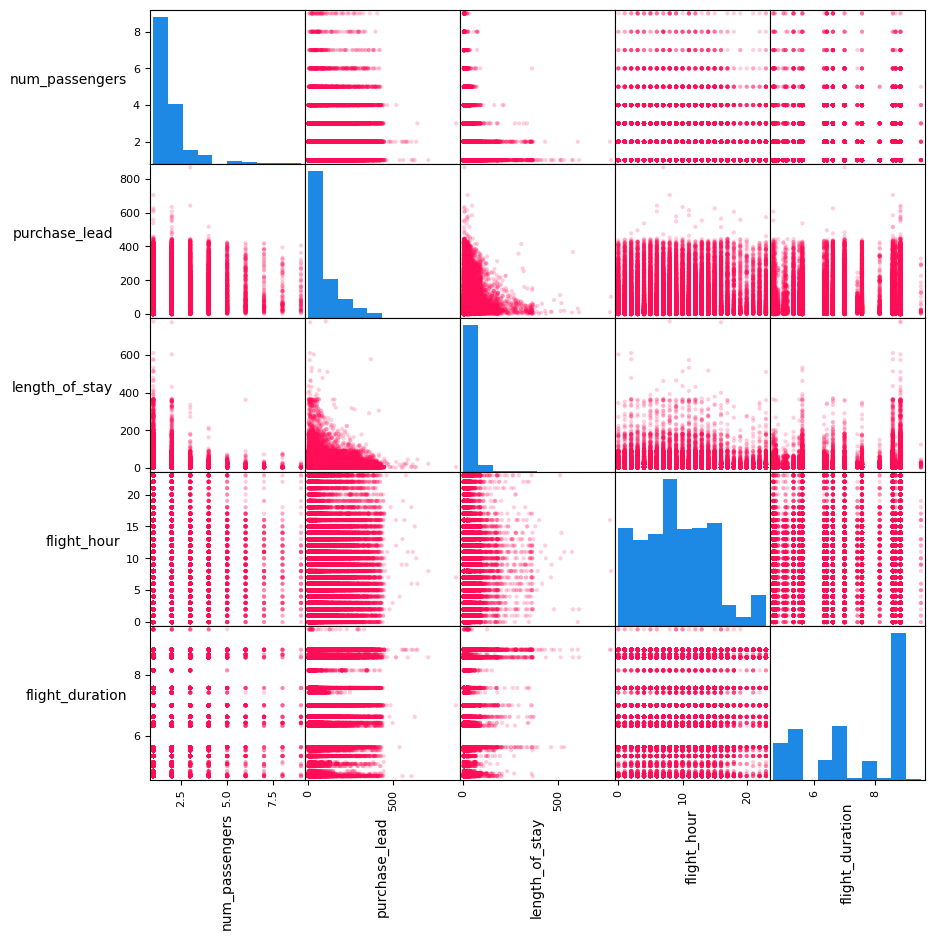

In [43]:
axes = pd.plotting.scatter_matrix(data[Num_cols], figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

**Insights**:

* There seems to be a concentration of points where both purchase lead and length of stay are low. This suggests that shorter trips are often booked with less lead time.
* There doesn’t seem to be a clear pattern indicating any relationship between flight hour and flight duration. This implies that the time of day may not significantly influence the duration of the flight booked.
* The scatter plots do not show distinct clusters or strong correlations between variables, suggesting that these factors might independently influence booking behaviors.

# Causal Analysis

**Causal Discovery**

In [13]:
#Encoding Categorical Columns
Cat_cols
Cat_cols_to_encode = ['sales_channel','trip_type', 'flight_day']

# performing One Hot Encoding
Cat_cols_to_encode = ['sales_channel', 'trip_type', 'flight_day']
df_encoded = pd.get_dummies(data, columns=Cat_cols_to_encode)

df_encoded


,num_passengers,purchase_lead,length_of_stay,flight_hour,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,flight_day_Fri,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed
0,2,262,19,7,AKLDEL,New Zealand,1,0,0,5.52,0,True,False,False,False,True,False,False,True,False,False,False,False
1,1,112,20,3,AKLDEL,New Zealand,0,0,0,5.52,0,True,False,False,False,True,False,False,True,False,False,False,False
2,2,243,22,17,AKLDEL,India,1,1,0,5.52,0,True,False,False,False,True,False,False,False,False,False,False,True
3,1,96,31,4,AKLDEL,New Zealand,0,0,1,5.52,0,True,False,False,False,True,False,False,True,False,False,False,False
4,2,68,22,15,AKLDEL,India,1,0,1,5.52,0,True,False,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,PERPNH,Australia,1,0,1,5.62,0,True,False,False,False,True,False,False,True,False,False,False,False
49996,1,111,6,4,PERPNH,Australia,0,0,0,5.62,0,True,False,False,False,True,False,False,False,True,False,False,False
49997,1,24,6,22,PERPNH,Australia,0,0,1,5.62,0,True,False,False,False,True,False,False,True,False,False,False,False
49998,1,15,6,11,PERPNH,Australia,1,0,1,5.62,0,True,False,False,False,True,False,True,False,False,False,False,False


In [14]:
Causal_df = df_encoded.drop(['route', 'booking_origin'], axis =1)
Causal_df

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,flight_day_Fri,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed
0,2,262,19,7,1,0,0,5.52,0,True,False,False,False,True,False,False,True,False,False,False,False
1,1,112,20,3,0,0,0,5.52,0,True,False,False,False,True,False,False,True,False,False,False,False
2,2,243,22,17,1,1,0,5.52,0,True,False,False,False,True,False,False,False,False,False,False,True
3,1,96,31,4,0,0,1,5.52,0,True,False,False,False,True,False,False,True,False,False,False,False
4,2,68,22,15,1,0,1,5.52,0,True,False,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,1,0,1,5.62,0,True,False,False,False,True,False,False,True,False,False,False,False
49996,1,111,6,4,0,0,0,5.62,0,True,False,False,False,True,False,False,False,True,False,False,False
49997,1,24,6,22,0,0,1,5.62,0,True,False,False,False,True,False,False,True,False,False,False,False
49998,1,15,6,11,1,0,1,5.62,0,True,False,False,False,True,False,True,False,False,False,False,False


In [53]:
from causallearn.search.HiddenCausal.GIN.GIN import GIN
G, K = GIN(Causal_df)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(G)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

AttributeError: 'float' object has no attribute 'shape'

In [58]:
labels = [f'{col}' for i, col in enumerate(Causal_df.columns)]

In [60]:
labels

['num_passengers',
 'purchase_lead',
 'length_of_stay',
 'flight_hour',
 'wants_extra_baggage',
 'wants_preferred_seat',
 'wants_in_flight_meals',
 'flight_duration',
 'booking_complete',
 'sales_channel_Internet',
 'sales_channel_Mobile',
 'trip_type_CircleTrip',
 'trip_type_OneWay',
 'trip_type_RoundTrip',
 'flight_day_Fri',
 'flight_day_Mon',
 'flight_day_Sat',
 'flight_day_Sun',
 'flight_day_Thu',
 'flight_day_Tue',
 'flight_day_Wed']

Starting in v1.3, whiten='unit-variance' will be used by default.
FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=5.859e-07, previous alpha=5.704e-07, with an active set of 14 regressors.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=1.445e-06, previous alpha=1.442e-06, with an active set of 14 regressors.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=6.400e-04, previous alpha=2.660e-04, with an active set of 17 regressors.


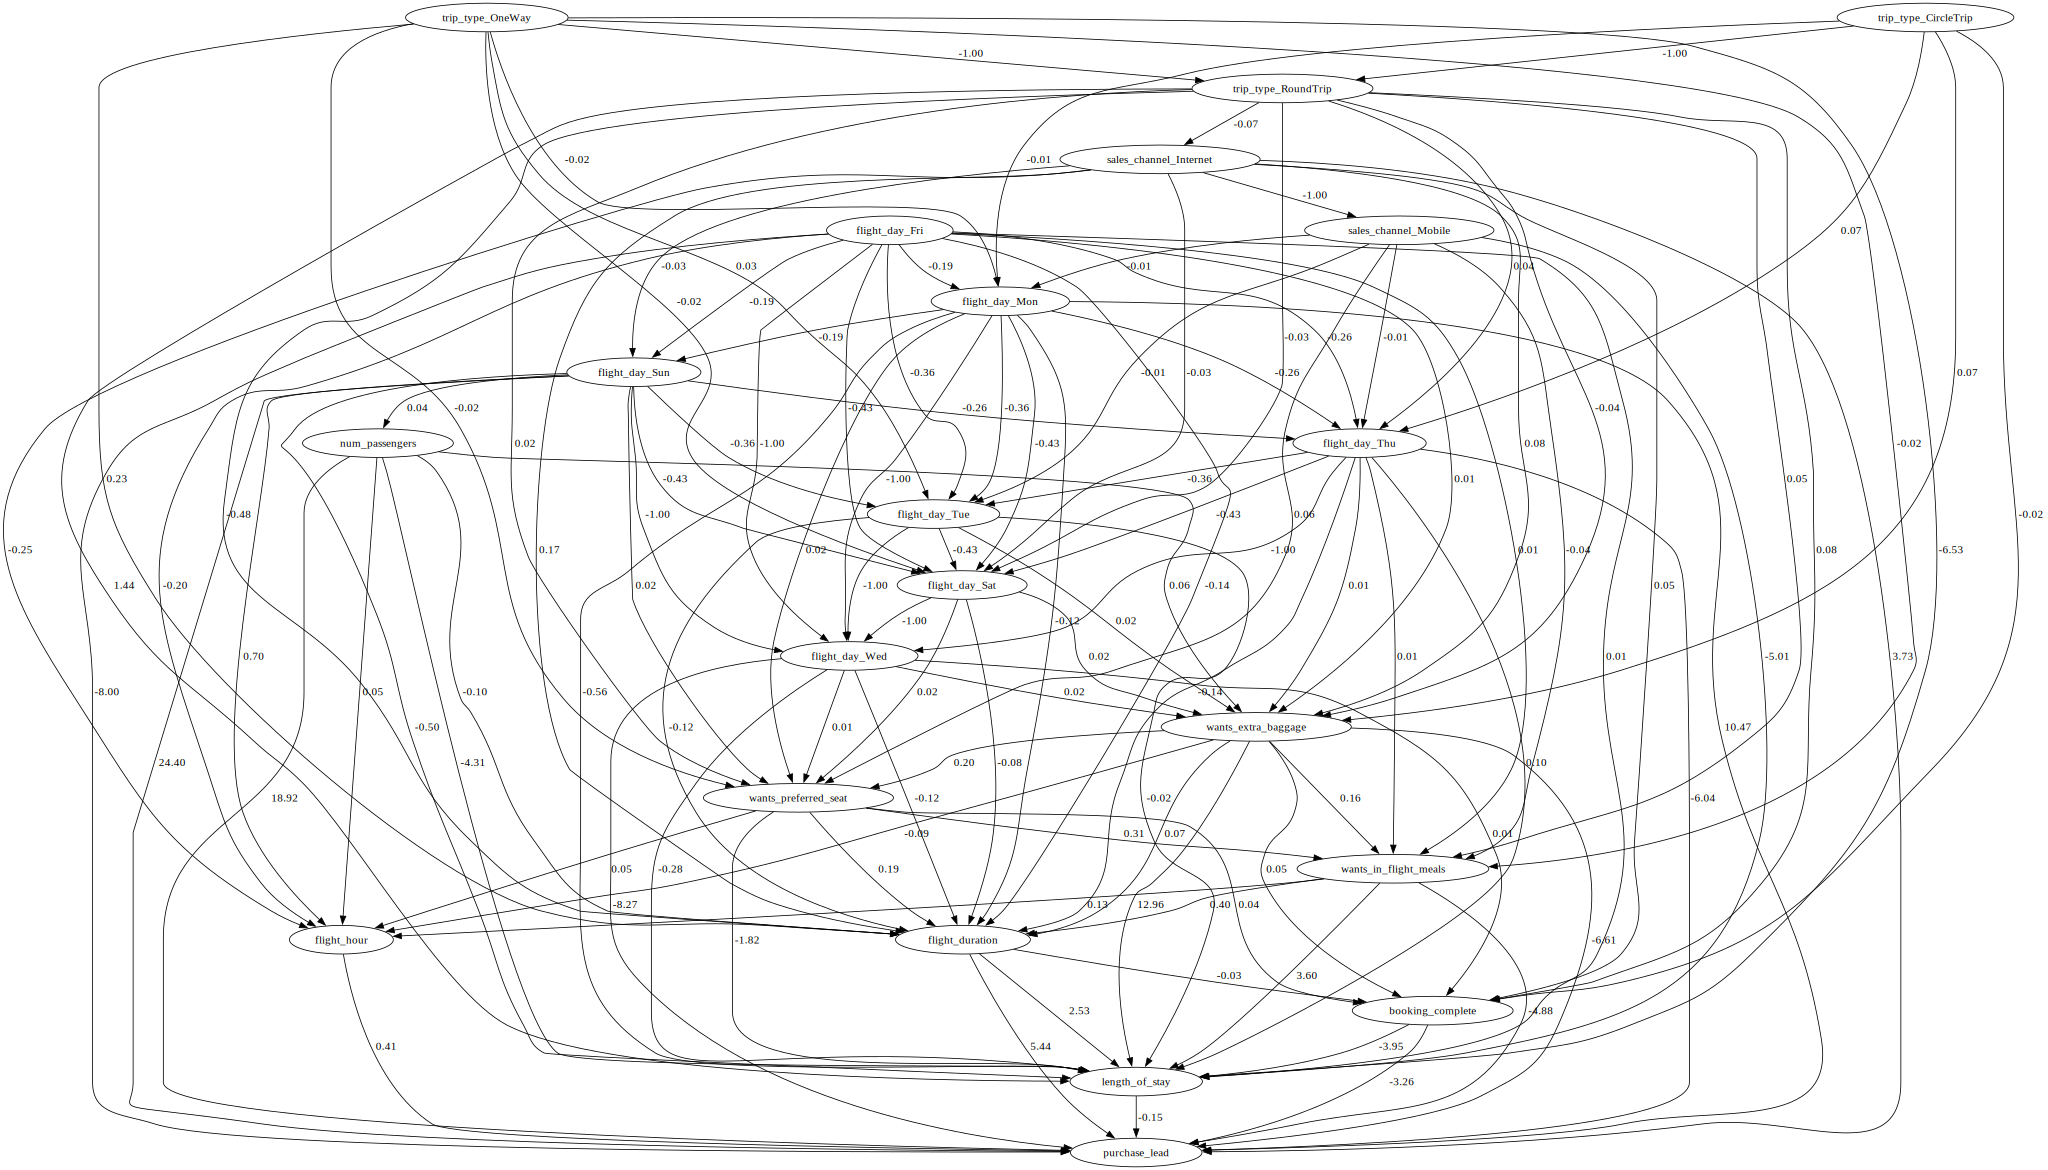

In [61]:
from causallearn.search.FCMBased import lingam


ICA_model = lingam.ICALiNGAM()
model.fit(Causal_df)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

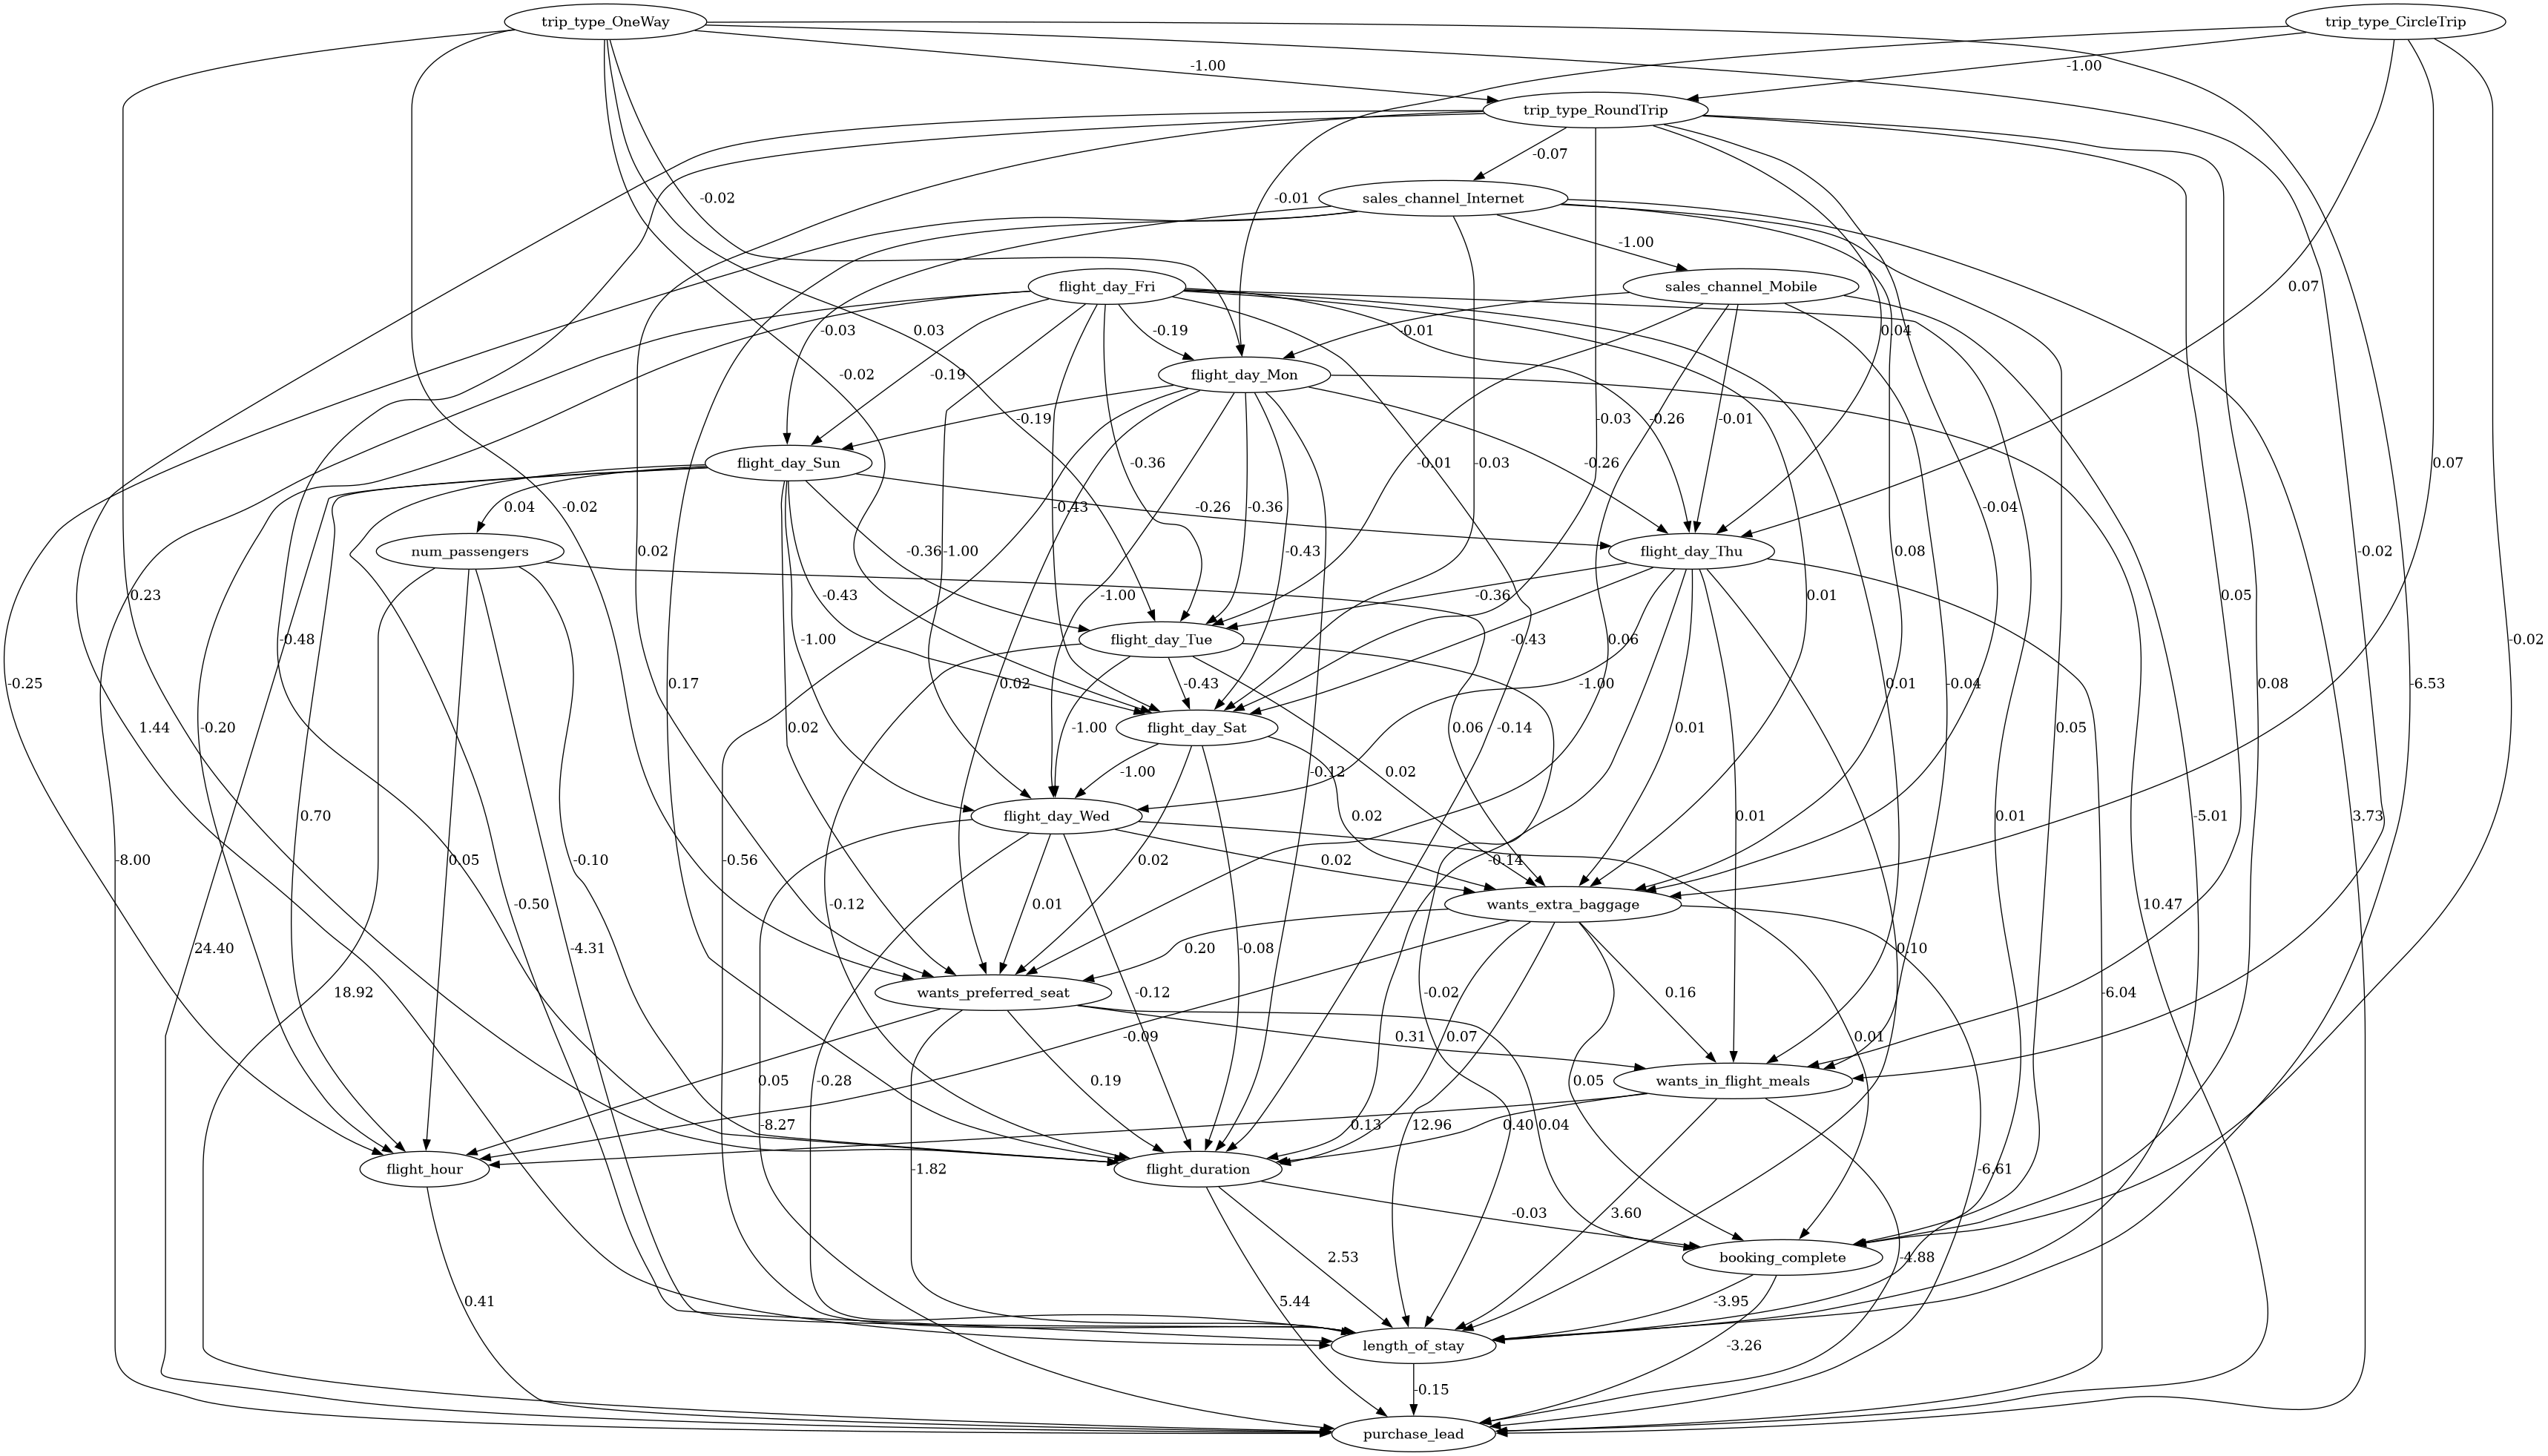

In [71]:
import graphviz
from IPython.display import Image

dot = make_dot(model.adjacency_matrix_, labels=labels)

dot.render('causal_dag', format='png', directory='/kaggle/working/')

display(Image(filename='/kaggle/working/causal_dag.png'))

In [7]:
import pygraphviz
causal_graph = """digraph {
    trip_type_OneWay [label="One Way Trip"];
    trip_type_RoundTrip [label="Round Trip"];
    trip_type_CircleTrip [label="Circle Trip"];
    booking_complete [label="Booking Status"];
    wants_preferred_seat [label="Seat Preference"];
    wants_extra_baggage [label="Extra Baggage Request"];
    flight_day_Fri [label="Flying on Friday"];
    flight_day_Sun [label="Flying on Sunday"];
    flight_day_Mon [label="Flying on Monday"];
    flight_day_Wed [label="Flying on Wednesday"];
    flight_day_Thu [label="Flying on Thursday"];
    wants_in_flight_meals [label="In-flight Meal Request"];
    flight_duration [label="Duration of Flight"];
    length_of_stay [label="Length of Stay"];
    purchase_lead [label="Lead Time"];
    num_passengers [label="No of Passengers"];
    sales_channel_internet [label="Sale through Internet"];
    sales_channel_mobile [label="Sale through Mobile"];
    sales_channel_internet -> purchase_lead;
    sales_channel_internet -> booking_complete;
    sales_channel_mobile -> length_of_stay;
    trip_type_OneWay -> length_of_stay;
    trip_type_RoundTrip -> booking_complete;
    trip_type_CircleTrip -> booking_complete;
    num_passengers -> length_of_stay;
    num_passengers -> purchase_lead;
    num_passengers -> wants_extra_baggage;
    booking_complete -> length_of_stay;
    wants_extra_baggage -> length_of_stay;
    wants_extra_baggage -> booking_complete;
    wants_extra_baggage -> purchase_lead;
    wants_preferred_seat -> booking_complete;
    wants_preferred_seat->flight_duration;
    wants_in_flight_meals -> length_of_stay;
    wants_in_flight_meals -> purchase_lead;
    wants_in_flight_meals -> flight_duration;
    trip_type_RoundTrip -> length_of_stay;
    flight_duration -> booking_complete;
    flight_duration -> purchase_lead;
    flight_duration -> length_of_stay;
    flight_day_Sun -> purchase_lead;
    flight_day_Mon -> purchase_lead;
    flight_day_Wed -> purchase_lead;
    flight_day_Wed -> booking_complete;
    flight_day_Thu -> purchase_lead;
    flight_day_Fri -> purchase_lead;
    purchase_lead -> booking_complete;
}"""

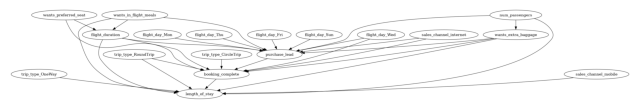

In [16]:
model= CausalModel(
        data = Causal_df,
        graph=causal_graph.replace("\n", " "),
        treatment="flight_duration",
        outcome='booking_complete')

model.view_model(file_name="/kaggle/working/causal_model_modified")



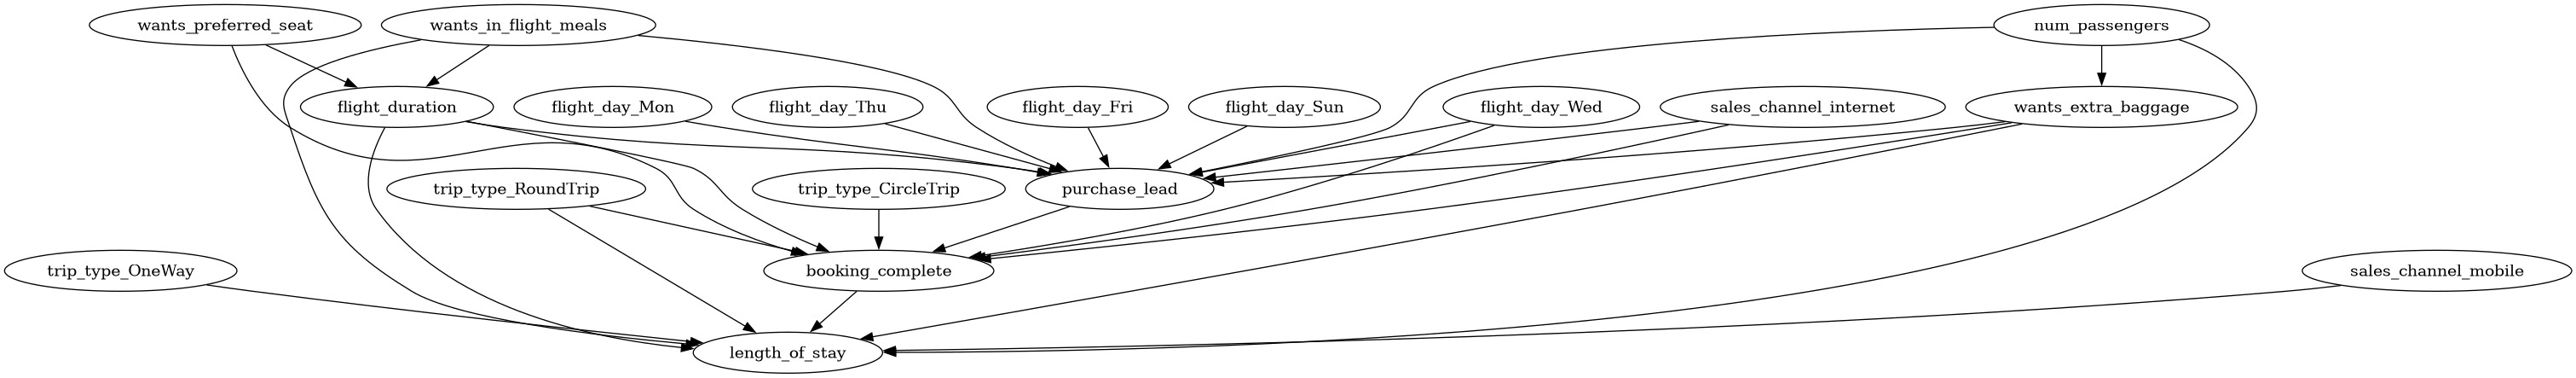

In [17]:
from IPython.display import Image, display
display(Image(filename="/kaggle/input/airline-booking-dag/causal_model_modified.png"))

In [18]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(E[booking_complete|wants_preferred_seat,wants_in_flight_mea
d[flight_duration]                                                            

    
ls])
    
Estimand assumption 1, Unconfoundedness: If U→{flight_duration} and U→booking_complete then P(booking_complete|flight_duration,wants_preferred_seat,wants_in_flight_meals,U) = P(booking_complete|flight_duration,wants_preferred_seat,wants_in_flight_meals)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



**Implement Doubly Robust Estimation**

In [19]:
Causal_df.columns


Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration', 'booking_complete', 'sales_channel_Internet',
       'sales_channel_Mobile', 'trip_type_CircleTrip', 'trip_type_OneWay',
       'trip_type_RoundTrip', 'flight_day_Fri', 'flight_day_Mon',
       'flight_day_Sat', 'flight_day_Sun', 'flight_day_Thu', 'flight_day_Tue',
       'flight_day_Wed'],
      dtype='object')

In [74]:
Causal_df = Causal_df.drop(['propensity_score', 'ips_weight', 'tips_weight',
       'cips_weight', 'ips_normalized_weight', 'tips_normalized_weight',
       'cips_normalized_weight', 'ips_stabilized_weight',
       'tips_stabilized_weight', 'cips_stabilized_weight', 'd_y', 'dbar_y'], axis =1 )
Causal_df.shape

In [22]:
#Step 1: Estimate the Generalized Propensity Score (GPS): We'll Model the treatment assignment 
#(flight_duration) using a regression model based on the covariates.

import statsmodels.api as sm
covariates = Causal_df.columns.to_list()
gps_model = sm.OLS(Causal_df['flight_duration'], sm.add_constant(Causal_df[covariates])).fit()
df['gps'] = gps_model.predict(sm.add_constant(Causal_df[covariates]))

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [23]:
Causal_df[covariates] = Causal_df[covariates].apply(pd.to_numeric, errors='coerce')

In [29]:
Causal_df.loc[:, Causal_df.select_dtypes(bool).columns] = Causal_df.select_dtypes(bool).astype(int)

# Confirm the changes
print(Causal_df.dtypes)

num_passengers              int64
purchase_lead               int64
length_of_stay              int64
flight_hour                 int64
wants_extra_baggage         int64
wants_preferred_seat        int64
wants_in_flight_meals       int64
flight_duration           float64
booking_complete            int64
sales_channel_Internet      int64
sales_channel_Mobile        int64
trip_type_CircleTrip        int64
trip_type_OneWay            int64
trip_type_RoundTrip         int64
flight_day_Fri              int64
flight_day_Mon              int64
flight_day_Sat              int64
flight_day_Sun              int64
flight_day_Thu              int64
flight_day_Tue              int64
flight_day_Wed              int64
dtype: object


Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please expli

In [24]:
covariates = [var for var in Causal_df.columns if var not in ['flight_duration', 'booking_complete']]

In [30]:
gps_model = sm.OLS(Causal_df['flight_duration'], sm.add_constant(Causal_df[covariates])).fit()
Causal_df['gps'] = gps_model.predict(sm.add_constant(Causal_df[covariates]))

In [33]:
# Step 2: Estimate the Outcome Model
outcome_model = sm.OLS(Causal_df['booking_complete'], sm.add_constant(Causal_df[['flight_duration'] + covariates])).fit()

In [35]:
# Step 3: Calculate the residuals from the outcome model
Causal_df['residuals'] = Causal_df['booking_complete'] - outcome_model.predict(sm.add_constant(Causal_df[['flight_duration'] + covariates]))

In [36]:
# Step 3: Apply GPS weights
Causal_df['weights'] = 1 / Causal_df['gps']  

In [37]:
# Step 4: Calculate the weighted average of the residuals
weighted_effect = np.average(Causal_df['residuals'], weights=Causal_df['weights'])

print(f"Estimated treatment effect: {weighted_effect}")

Estimated treatment effect: 2.8463935002765067e-05


In [40]:
Causal_df_gcm = Causal_df.drop(['gps', 'residuals', 'weights'], axis =1)
Causal_df_gcm

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,flight_day_Fri,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed
0,2,262,19,7,1,0,0,5.52,0,1,0,0,0,1,0,0,1,0,0,0,0
1,1,112,20,3,0,0,0,5.52,0,1,0,0,0,1,0,0,1,0,0,0,0
2,2,243,22,17,1,1,0,5.52,0,1,0,0,0,1,0,0,0,0,0,0,1
3,1,96,31,4,0,0,1,5.52,0,1,0,0,0,1,0,0,1,0,0,0,0
4,2,68,22,15,1,0,1,5.52,0,1,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,1,0,1,5.62,0,1,0,0,0,1,0,0,1,0,0,0,0
49996,1,111,6,4,0,0,0,5.62,0,1,0,0,0,1,0,0,0,1,0,0,0
49997,1,24,6,22,0,0,1,5.62,0,1,0,0,0,1,0,0,1,0,0,0,0
49998,1,15,6,11,1,0,1,5.62,0,1,0,0,0,1,0,1,0,0,0,0,0


# **Trying GCM: Exploratory Causal Analysis**

In [47]:
causal_graph_gcm = nx.DiGraph([
    ('sales_channel_Internet', 'purchase_lead'),
    ('sales_channel_Internet', 'booking_complete'),
    ('sales_channel_Mobile', 'length_of_stay'),
    ('trip_type_OneWay', 'length_of_stay'),
    ('trip_type_RoundTrip', 'booking_complete'),
    ('trip_type_CircleTrip', 'booking_complete'),
    ('num_passengers', 'length_of_stay'),
    ('num_passengers', 'purchase_lead'),
    ('num_passengers', 'wants_extra_baggage'),
    ('booking_complete', 'length_of_stay'),
    ('wants_extra_baggage', 'length_of_stay'),
    ('wants_extra_baggage', 'booking_complete'),
    ('wants_extra_baggage', 'purchase_lead'),
    ('wants_preferred_seat', 'booking_complete'),
    ('wants_preferred_seat', 'flight_duration'),
    ('wants_in_flight_meals', 'length_of_stay'),
    ('wants_in_flight_meals', 'purchase_lead'),
    ('wants_in_flight_meals', 'flight_duration'),
    ('trip_type_RoundTrip', 'length_of_stay'),
    ('flight_duration', 'booking_complete'),
    ('flight_duration', 'purchase_lead'),
    ('flight_duration', 'length_of_stay'),
    ('flight_day_Sun', 'purchase_lead'),
    ('flight_day_Mon', 'purchase_lead'),
    ('flight_day_Wed', 'purchase_lead'),
    ('flight_day_Wed', 'booking_complete'),
    ('flight_day_Thu', 'purchase_lead'),
    ('flight_day_Fri', 'purchase_lead'),
    ('purchase_lead', 'booking_complete')
])


In [44]:
Causal_df_gcm

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,flight_day_Fri,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed
0,2,262,19,7,1,0,0,5.52,0,1,0,0,0,1,0,0,1,0,0,0,0
1,1,112,20,3,0,0,0,5.52,0,1,0,0,0,1,0,0,1,0,0,0,0
2,2,243,22,17,1,1,0,5.52,0,1,0,0,0,1,0,0,0,0,0,0,1
3,1,96,31,4,0,0,1,5.52,0,1,0,0,0,1,0,0,1,0,0,0,0
4,2,68,22,15,1,0,1,5.52,0,1,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,1,0,1,5.62,0,1,0,0,0,1,0,0,1,0,0,0,0
49996,1,111,6,4,0,0,0,5.62,0,1,0,0,0,1,0,0,0,1,0,0,0
49997,1,24,6,22,0,0,1,5.62,0,1,0,0,0,1,0,0,1,0,0,0,0
49998,1,15,6,11,1,0,1,5.62,0,1,0,0,0,1,0,1,0,0,0,0,0


In [48]:
causal_model = gcm.StructuralCausalModel(causal_graph_gcm)

gcm.auto.assign_causal_mechanisms(causal_model, Causal_df_gcm)

Test permutations of given graph: 100%|██████████| 50/50 [04:15<00:00,  5.11s/it]


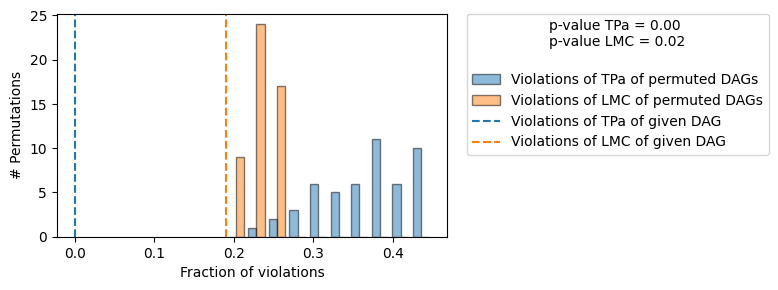

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [49]:
gcm.fit(causal_model, Causal_df_gcm)
print(gcm.evaluate_causal_model(causal_model, Causal_df_gcm))